# Average Faces
## The purpose is to combine all frames from the Train dataset.
## The goal is to see if there is an average facial location difference between genders.
## The results are not very helpful.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.models import load_model
import os

from matplotlib import image

from PIL import Image, ImageOps

In [5]:
labels = pd.read_csv(os.path.join(os.pardir, 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.pardir, 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.pardir, 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

valLabels = pd.read_csv(os.path.join(os.pardir, 'dataset', 'Labels', 'TrainLabels.csv'))

missing = len(set(valLabels['ClipID'].values.tolist()) - set(labels['ClipID'].values.tolist()))
print(f'There are {missing} samples without labels!')

labels['ID_num'] = labels['ClipID'].str[:-4]
# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

labels.drop(['male', 'female'], axis=1, inplace=True)
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

labels['ID'] = labels['ClipID'].str[:-4]
labels['ID'] = pd.to_numeric(labels['ID'])

There are 0 samples without labels!


In [23]:
labels['gender'].describe()

count    8925.000000
mean        0.697815
std         0.459231
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

In [25]:
train_path = os.path.join(os.pardir, 'dataset/Train/')

male_accumulator = np.zeros(shape=(224,299), dtype='float32')
male_count = 0
female_accumulator = np.zeros(shape=(224,299), dtype='float32')
female_count = 0

print("building validation set")
missing_count = 0

for filename in tqdm(os.listdir(train_path)):
    try:
        sample_ID = filename[:filename.index('-')]
        row = labels[labels['ID_num']==sample_ID]
        gender = row['gender'].values[0]
        
        img_path = os.path.join(train_path, filename)
        img = ImageOps.grayscale(Image.open(img_path))
        
        if gender==0:
            female_accumulator += np.array(img, dtype='float32') / 255
            female_count += 1
        elif gender==1:
            male_accumulator += np.array(img, dtype='float32') / 255
            male_count += 1
        else:
            raise Exception('Gender unknown')
        
    except IndexError:
        missing_count += 1
        
print(f'There are {missing_count} samples without labels!')

building validation set


100%|███████████████████████████████████████████████████████████████████████████| 38374/38374 [01:18<00:00, 488.98it/s]

There are 0 samples without labels!


In [22]:
male_count

38374

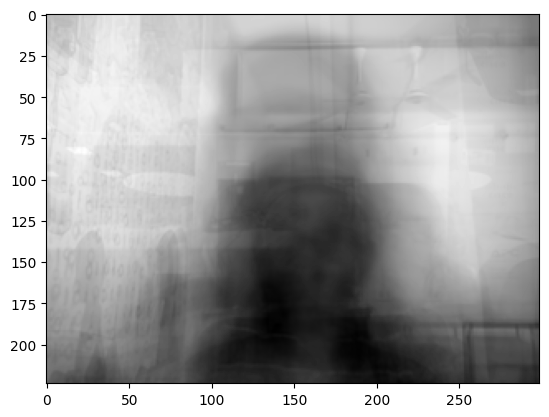

In [29]:
average_female = female_accumulator / female_count
average_female *= 255
plt.imshow(average_female, cmap='gray')

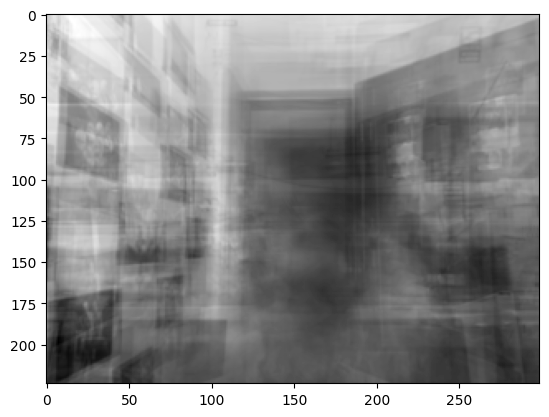

In [28]:
average_male = male_accumulator / male_count
average_male *= 255
plt.imshow(average_male, cmap='gray')